Surface Defect Classification with TensorFlow
Objective:
The goal of this project is to develop a machine learning model that can classify surface defects in images. I useD the NEU Surface Defect Database from Kaggle, and employed a Convolutional Neural Network (CNN) with the Xception architecture for image classification.

In [1]:
import os
import tensorflow as tf
import xml.etree.ElementTree as ET
import glob
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Dense, Dropout
from tensorflow.keras.models import Model


In [2]:
#checking for tensorflow version 
tf.__version__         

'2.15.0'

In [3]:
def generate_sample_tf(annotation_path, image_folder):
    
    ''' The goal is to convert image annotations (stored in XML format) and the images themselves into TensorFlow's TFRecord format, 
        which is more efficient for training TensorFlow models'''

    #parse the XML file containing annotations
    tree = ET.parse(annotation_path)    
    root = tree.getroot() 

    # Reading the width, height and filename from xml file
    width = int(root.find('size/width').text)        
    height = int(root.find('size/height').text)
    filename = root.find('filename').text
    
    # Handling xml files which do not have .jpg in annotations filename
    if not filename.lower().endswith('.jpg'):        
        filename += '.jpg'

    #these lists are initiated and used to store bounding box normalized coordinates of all objects in XML
    xmins, xmaxs, ymins, ymaxs = [], [], [], []     
    class_label = None

    # Loop through all objects in the XML
    for obj in root.findall('object'):             
        class_label = obj.find('name').text.encode('utf8')
        
        # Extract bounding box coordinates and normalize them
        bbox = obj.find('bndbox')                   
        xmin = float(bbox.find('xmin').text) / width        
        xmax = float(bbox.find('xmax').text) / width
        ymin = float(bbox.find('ymin').text) / height
        ymax = float(bbox.find('ymax').text) / height
        xmins.append(xmin)
        xmaxs.append(xmax)
        ymins.append(ymin)
        ymaxs.append(ymax)

    # Generating image path based on the class folder
    class_folder = class_label.decode('utf8').lower()
    image_path = os.path.join(image_folder, class_folder, filename)

    # Checking if the image file exists in the expected class folder
    if not os.path.exists(image_path):
        # If the image file is not there, search for the file in other class folders
        for folder in os.listdir(image_folder):
            potential_path = os.path.join(image_folder, folder, filename)
            if os.path.exists(potential_path):
                image_path = potential_path
                break

    # Read image data, which is later used for encodedrawdata in feature dictionary
    with open(image_path, 'rb') as image_file:
        encoded_image_data = image_file.read()

    # Creating a dictionary for required features  
    feature = {
        "image/width": tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        "image/height": tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/filename': tf.train.Feature(bytes_list=tf.train.BytesList(value=[filename.encode('utf8')])),
        'image/source_id': tf.train.Feature(bytes_list=tf.train.BytesList(value=[filename.encode('utf8')])),
        'image/encodedrawdata': tf.train.Feature(bytes_list=tf.train.BytesList(value=[encoded_image_data])),
        'image/format': tf.train.Feature(bytes_list=tf.train.BytesList(value=[b'jpg'])),
        'image/object/bbox/xmin': tf.train.Feature(float_list=tf.train.FloatList(value=xmins)),
        'image/object/bbox/xmax': tf.train.Feature(float_list=tf.train.FloatList(value=xmaxs)),
        'image/object/bbox/ymin': tf.train.Feature(float_list=tf.train.FloatList(value=ymins)),
        'image/object/bbox/ymax': tf.train.Feature(float_list=tf.train.FloatList(value=ymaxs)),
        'image/object/class/text': tf.train.Feature(bytes_list=tf.train.BytesList(value=[class_label])),
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

def generate_tf_records(dataset_path, output_folder):
    '''This function iterates through each XML annotation file in the provided dataset path.
       For each annotation file, it creates a TFRecord file containing the image data and corresponding annotations. '''
    annotation_folder = os.path.join(dataset_path, 'annotations')
    image_folder = os.path.join(dataset_path, 'images')

    # Checking for output folder and creating if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for annotation_file in os.listdir(annotation_folder):
        if annotation_file.endswith('.xml'):
            annotation_path = os.path.join(annotation_folder, annotation_file)
            tf_sample = generate_sample_tf(annotation_path, image_folder)

            # Assigning output path based on the annotation filename
            output_path = os.path.join(output_folder, annotation_file.replace('.xml', '.tfrecord'))

            with tf.io.TFRecordWriter(output_path) as writer:
                writer.write(tf_sample.SerializeToString())

if __name__ == '__main__':
    generate_tf_records('D:/TASK/archive/NEU-DET/train', 'D:/TASK/archive/NEU-DET/tfrecord_full/train')           #(source_folder, destination_folder)
    generate_tf_records('D:/TASK/archive/NEU-DET/validation', 'D:/TASK/archive/NEU-DET/tfrecord_full/validation')


In [4]:
# Defining a label map for converting class labels to integers
label_map = {'crazing': 0, 'inclusion': 1, 'patches': 2, 'pitted_surface': 3, 'rolled-in_scale': 4, 'scratches': 5}

In [5]:
# Defining a function to parse a TensorFlow Example from a TFRecord file
def _parse_function(serialized_example):
    # Giving the required feature description for parsing
    feature_description = {
        "image/encodedrawdata": tf.io.FixedLenFeature([], tf.string),
        'image/object/class/text': tf.io.FixedLenFeature([], tf.string),
    }

    # Parse the input `tf.train.Example` proto using the feature description.
    parsed_features = tf.io.parse_single_example(serialized_example, feature_description)

    # Decode the image as grayscale
    image = tf.image.decode_jpeg(parsed_features["image/encodedrawdata"], channels=1)
    image.set_shape([None, None, 1])

    # Converting the class label from string to integer using a lookup table
    def map_label(label_str):
        label_str = label_str.numpy().decode()
        return label_map[label_str]

    label = tf.py_function(map_label, [parsed_features['image/object/class/text']], tf.int32)

    label.set_shape([])

    return image, label



In [6]:
# Defining a function to load and parse a dataset from TFRecord files
def load_dataset(filepaths):
    raw_dataset = tf.data.TFRecordDataset(filepaths)   # Load the TFRecord files
    parsed_dataset = raw_dataset.map(_parse_function)   # Parse the TFRecords
    return parsed_dataset

# Obtaining the list of TFRecord files for the train and validation datasets
train_tfrecord_files = glob.glob('D:/TASK/archive/NEU-DET/tfrecord_full/train/*.tfrecord')
validation_tfrecord_files = glob.glob('D:/TASK/archive/NEU-DET/tfrecord_full/validation/*.tfrecord')

# Creating train and validation datasets from tfrecords
train_dataset = load_dataset(train_tfrecord_files)
validation_dataset = load_dataset(validation_tfrecord_files)


Samples from Train Dataset:


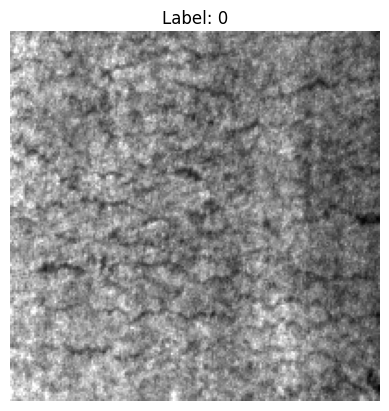

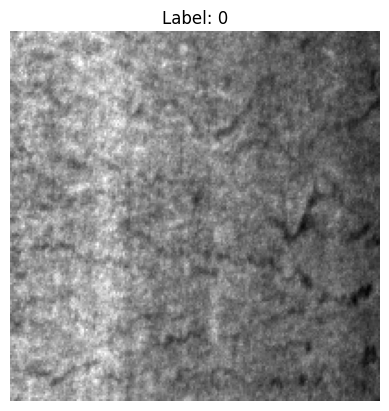

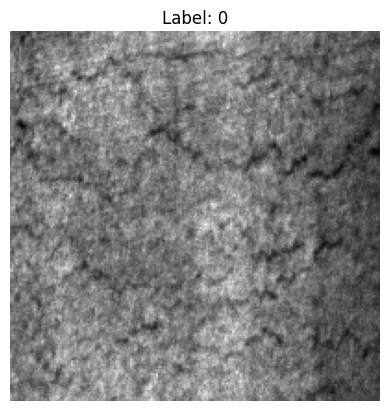

Samples from Validation Dataset:


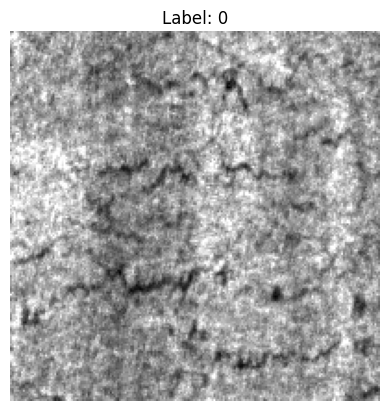

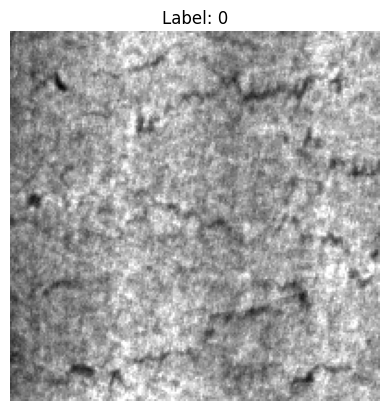

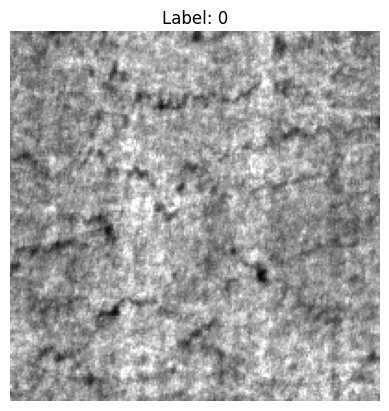

In [7]:
def show_samples(dataset, num_samples=3):
    # Iterate through the dataset and show samples
    for image, label in dataset.take(num_samples):
        plt.figure()
        plt.imshow(image.numpy().squeeze(), cmap='gray')  # depth in xml is 1 so gray image
        plt.title(f'Label: {label.numpy()}')
        plt.axis('off')
        plt.show()

# Show samples from the train dataset
print("Samples from Train Dataset:")
show_samples(train_dataset)

# Show samples from the validation dataset
print("Samples from Validation Dataset:")
show_samples(validation_dataset)


PREPROCESS IMAGES 

In [8]:
def preprocess_image(image, label):
    # Resize the images to 200x200
    image = tf.image.resize(image, (200, 200))
    # Scale pixel values to [-1, 1]
    image = (image / 127.5) - 1
    # Replicate the grayscale channel across three channels
    image = tf.tile(image, [1, 1, 3])
    return image, label



In [9]:
batch_size = 32  # The number of samples per batch
epochs = 10      # The number of times to iterate over the entire dataset

buffer_size = 1000  # Used for shuffle so that model goes through all samples

# Prepare the training dataset
train_dataset = train_dataset.map(preprocess_image)
train_dataset = train_dataset.shuffle(buffer_size=buffer_size)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE) 

# Prepare the validation dataset
validation_dataset = validation_dataset.map(preprocess_image)
validation_dataset = validation_dataset.batch(batch_size)
validation_dataset = validation_dataset.prefetch(tf.data.AUTOTUNE)

In [10]:
# Checking the shape of the images and labels in the first batch of the training dataset
for images, labels in train_dataset.take(1):
    print(images.shape, labels.shape)


(32, 200, 200, 3) (32,)


MODEL TO PERFORM IMAGE CLASSIFICATION

In [11]:
# Loading the given base Xception model with the appropriate input shape
base_model = Xception(include_top=False, weights='imagenet', input_shape=(200, 200, 3))

# Freezing the base model layers and adding custom head
base_model.trainable = False

# Adding the custom head for classification
x = base_model.output
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
x = Dense(8, activation='relu')(x)
x = Dropout(0.4)(x)
predictions = Dense(len(label_map), activation='relu')(x) #relu is used as per description. Normally I go so softmax

# final model
model = Model(inputs=base_model.input, outputs=predictions)

# learning rate decay schedule is used for better optimization
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=100,
    decay_rate=0.96,
    staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])




TRAINING THE MODEL

In [12]:
history = model.fit(train_dataset, epochs=epochs, validation_data=validation_dataset)


Epoch 1/10


45/45 [==============================] - 107s 2s/step - loss: 1.3471 - accuracy: 0.5000 - val_loss: 1.3274 - val_accuracy: 0.7611
Epoch 2/10
45/45 [==============================] - 95s 2s/step - loss: 0.9231 - accuracy: 0.6417 - val_loss: 1.0742 - val_accuracy: 0.8306
Epoch 3/10
45/45 [==============================] - 93s 2s/step - loss: 0.8502 - accuracy: 0.6722 - val_loss: 0.9013 - val_accuracy: 0.8639
Epoch 4/10
45/45 [==============================] - 96s 2s/step - loss: 0.7832 - accuracy: 0.6958 - val_loss: 0.7554 - val_accuracy: 0.8583
Epoch 5/10
45/45 [==============================] - 92s 2s/step - loss: 0.7648 - accuracy: 0.6972 - val_loss: 0.6578 - val_accuracy: 0.8833
Epoch 6/10
45/45 [==============================] - 89s 2s/step - loss: 0.6982 - accuracy: 0.7285 - val_loss: 0.5769 - val_accuracy: 0.8833
Epoch 7/10
45/45 [==============================] - 89s 2s/step - loss: 0.7151 - accuracy: 0.7340 - val_loss: 0.5335 - val_accuracy: 0.8944
Epoch 8/10
45/45 

Learning curves

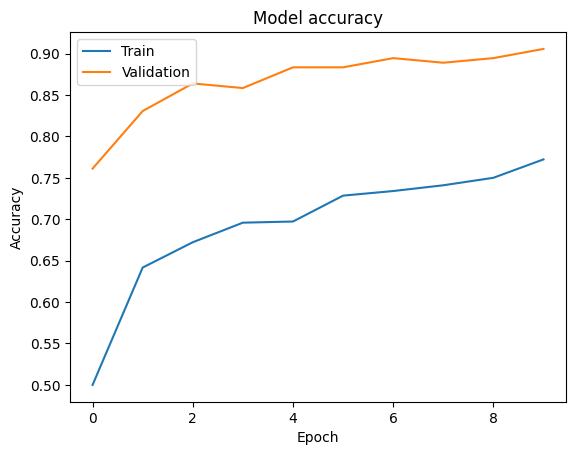

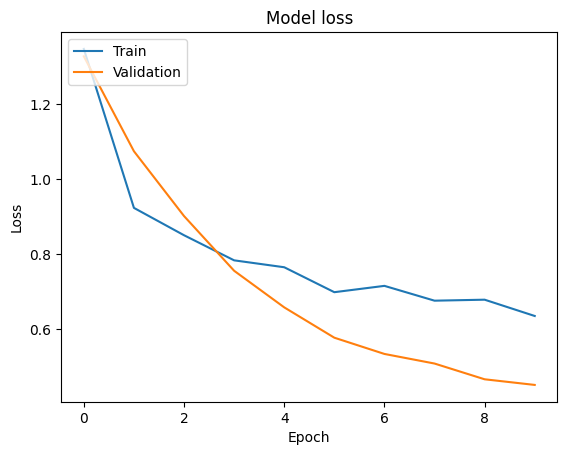

In [13]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


CONFUSION CHART 

1/1 [==============================] - 0s 94ms/step


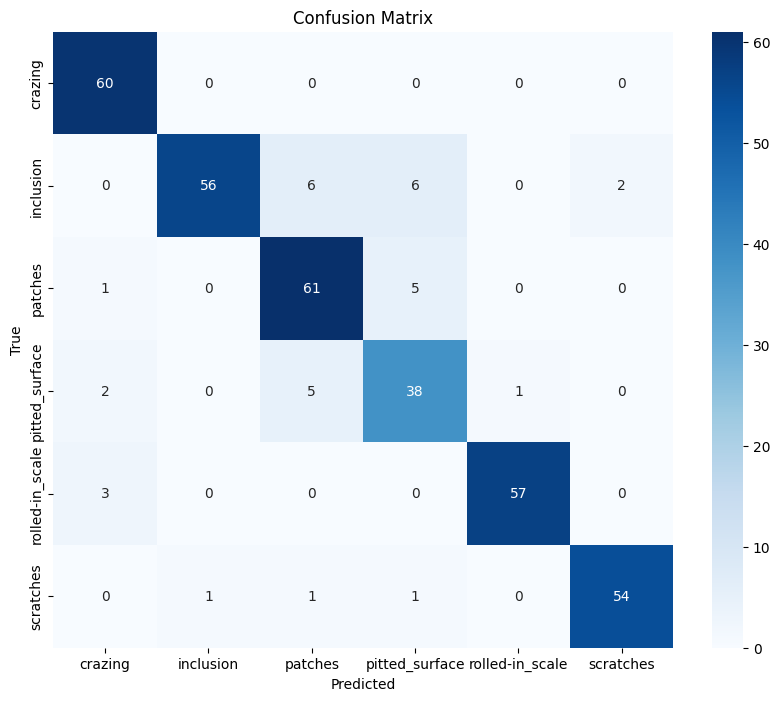

In [14]:
# Initialize lists to hold the true labels and predictions
y_true = []
y_pred = []

# Iterate over the dataset
for images, labels in validation_dataset.unbatch().as_numpy_iterator():
    y_true.append(labels)  # Append the true label
    preds = model.predict(np.expand_dims(images, axis=0))  # Predict with model
    y_pred.append(np.argmax(preds, axis=1)[0])  # Append the predicted label

# Convert lists to numpy arrays for confusion matrix computation
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=list(label_map.keys()), yticklabels=list(label_map.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [15]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=label_map.keys()))


                 precision    recall  f1-score   support

        crazing       0.91      1.00      0.95        60
      inclusion       0.98      0.80      0.88        70
        patches       0.84      0.91      0.87        67
 pitted_surface       0.76      0.83      0.79        46
rolled-in_scale       0.98      0.95      0.97        60
      scratches       0.96      0.95      0.96        57

       accuracy                           0.91       360
      macro avg       0.91      0.91      0.90       360
   weighted avg       0.91      0.91      0.91       360



In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 99, 99, 32)           864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 99, 99, 32)           128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 99, 99, 32)           0         ['block1_conv1_bn[0][0]'] 